<a href="https://colab.research.google.com/github/zhaoyaqi125/Assessment/blob/main/Assessment_DL_NOV2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment / Midterm: Machine Vision and Deep Learning
<span style="color:blue">
    
1) Answer all questions
    
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc

3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)

4) Upload the answer notebook & trained model (for Question 3) to your github. 

5) Submit the assessment by sharing the link to your github containing the answers. 
    
</span>

**QUESTION 1 [15 marks]**

a) Let *k*, *s* and *p* be 4, 2 and 1, respectively. What will be the shape of the output of the convolutional layer? (2 marks)

>>import torch \
import torch.nn as nn \
input_img = torch.rand(1,3,10,10) \
layer = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=*k*, stride=*s*, padding=*p*)

<span style="color:blue">
    answer: The shape of the output is [1, 12, 5, 5]
</span>

b) Batch Normalization (BN) normalizes the mean and standard deviation for each: (tick X for the correct answer) (2 marks)

 - [x] Individual feature map
 - [ ] Instance in the mini-batch
 - [ ] Spatial dimension    

c) Which one of the following is not an advantage of Batch Normalization (BN)? (tick X for the correct answer) (2 marks)

- [ ] BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.
- [ ] For every input mini-batch, we calculate different statistics. This introduces some sort of regularization.
- [ ] BN reduces the dependence of gradients on the scale of the parameters or of their initial values.
- [x] BN needs a much slower learning rate for the total architecture to converge.

d) Choose the correct statement. (tick X for the correct answer) (2 marks)

- [x] A larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.
- [ ] A larger kernel is preferred for information that resides locally, and a smaller kernel is preferred for information that is distributed globally.

e) In the following network, how many learnable parameters (weights) are there? (2 marks)

In [ ]:
model = nn.Sequential(
        nn.Linear(3,20),
        nn.ReLU(),
        nn.Linear(20,2)
    )

<span style="color:blue">
    answer: There are 20 learnable parameters.
</span>

f) Which of the following statements are true about deep neural networks? (tick X for the correct answer) (2 marks)

- [x] Deep neural networks usually require a big amount of data to be properly trained.
- [ ] They can be fooled by adversarial/ noisy examples.
- [ ] They are difficult to interpret and understand.
- [ ] They can still be subject to biases.
- [ ] They fail to understand the context of the data that they are handling.
- [ ] They perform very well on individual tasks but fail to generalize to many different tasks.

g) Run the code in the next cell. 

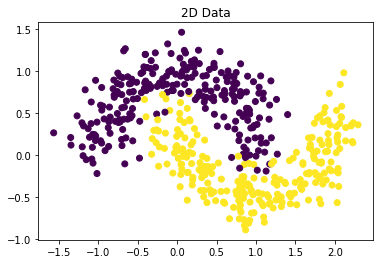

In [ ]:
# import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

# generate synthetic data in 2D
X, Y = make_moons(500, noise=0.2)

# plot the data
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title('2D Data')
plt.show()

Can this data be correctly separable using the classifier below? Why? (3 marks)

model = nn.Sequential( \
    nn.Linear(n_input_dim, n_output), \
    nn.Sigmoid() \
    )
    
<span style="color:blue">
    answer: Yes it is separable, because it uses a sequential order of individual layers.
</span>

**QUESTION 2 [50 marks]** 

The COVID-19 pandemic continues to have a devastating effect on the health and well-being of the global population. A critical step in the fight against COVID-19 is effective screening of infected patients, with one of the key screening approaches being radiology examination using chest radiography. As a deep learning engineer, you are tasked to classify a dataset of X-ray images as either "normal", "covid" or "viral pneumonia". Use the chest X-ray dataset publicly available at https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset to answer the following questions.


a) Train a feedforward neural network to solve the classification problem. Please include: **(10 marks)**

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) The training loop.

    4) Output the mean accuracy for the whole testing dataset.
    
    5) The hyperparameters are:
        i  - architecture: 2 hidden layers
        ii - input size  : 32x32 

In [5]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [6]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms
im_size=32;
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_size, im_size)),
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_size, im_size)),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [9]:
# Load the Data

# Set train and valid directory paths

from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/DLIVACV_workshop/Covid19-dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
batchSize = 4

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
 #idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
 #print(idx_to_class)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
3


In [10]:
data['train']

Dataset ImageFolder
    Number of datapoints: 251
    Root location: /content/gdrive/My Drive/DLIVACV_workshop/Covid19-dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [12]:
train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

251
66


In [13]:
input_size = (3,32,32)

In [14]:
class myModel(nn.Module): 
    def __init__(self): 
        super(myModel, self).__init__() 
        self.linear1 = nn.Linear(3072, 128) 
        self.linear2 = nn.Linear(128, 64) 
        self.linear3 = nn.Linear(64, 3) 
        self.relu = nn.ReLU()
  
    def forward(self, x): 
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        o = self.linear3(x)

        return o 
    
model = myModel()

In [15]:
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

myModel(
  (linear1): Linear(in_features=3072, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)

In [16]:
device

device(type='cpu')

In [17]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            #reshape images so they can be fed to a nn.Linear()
            inputs = inputs.view(inputs.size(0), -1)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                #reshape images so they can be fed to a nn.Linear()
                inputs = inputs.view(inputs.size(0), -1)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [18]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.6005, Accuracy: 78.8845%, 
		Validation : Loss : 0.5249, Accuracy: 74.2424%, Time: 51.5544s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.2781, Accuracy: 89.6414%, 
		Validation : Loss : 0.4804, Accuracy: 80.3030%, Time: 17.1020s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2238, Accuracy: 91.6335%, 
		Validation : Loss : 0.4119, Accuracy: 84.8485%, Time: 17.0896s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1571, Accuracy: 96.8127%, 
		Validation : Loss : 0.3696, Accuracy: 89.3939%, Time: 17.0826s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1339, Accuracy: 94.8207%, 
		Validation : Loss : 0.3776, Accuracy: 89.3939%, Time: 17.0948s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1132, Accuracy: 96.4143%, 
		Validation : Loss : 0.3617, Accuracy: 84.8485%, Time: 17.1234s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0931, Accuracy: 98.0080%, 
		Validation : Loss : 0.3459, Accuracy: 87.8788%, Time: 17.3824s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0689, Accura

In [19]:
history

[[0.6005322164985764,
  0.5248999722076185,
  0.7888446215139442,
  0.7424242424242424],
 [0.2781458008158729,
  0.48038881384965143,
  0.896414342629482,
  0.803030303030303],
 [0.22382638365980165,
  0.41193323424368194,
  0.9163346613545816,
  0.8484848484848485],
 [0.15709959166458404,
  0.3696174918476379,
  0.9681274900398407,
  0.8939393939393939],
 [0.13394554875479395,
  0.37759177756467555,
  0.9482071713147411,
  0.8939393939393939],
 [0.11317256968691054,
  0.3617046184724931,
  0.9641434262948207,
  0.8484848484848485],
 [0.09308908431905794,
  0.34594750212449016,
  0.9800796812749004,
  0.8787878787878788],
 [0.06893799635785747,
  0.42687802897258237,
  0.9840637450199203,
  0.8333333333333334],
 [0.06335108861534956,
  0.3920041871341792,
  0.9880478087649402,
  0.8484848484848485],
 [0.048953818864155695,
  0.32984972564559994,
  0.9920318725099602,
  0.8939393939393939]]

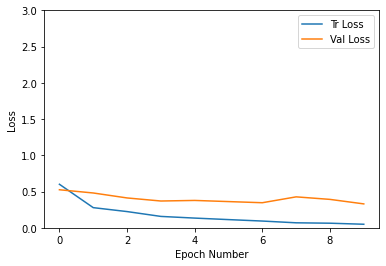

In [20]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

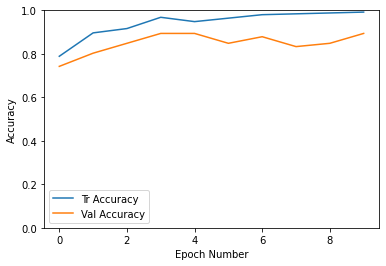

In [21]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

b) Create and train a ConvNet corresponding to the following architecture in Fig. 1 (with modifications of the input and final layers). Please include **(10 marks)**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)
    
                                Fig. 1: A convolutional neural network

In [25]:
#1. DEFINE THE CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(16 * 5* 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [27]:
# to check how many parameters in our model:

import torch
from torchvision import models
from torchsummary import summary

model = CNN()
model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 10]           1,210
Total params: 52,202
Trainable params: 52,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.20
Estimated Total Size (MB): 0.32
---------------------------------------------

In [28]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [29]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 2.3261, Accuracy: 18.7251%, 
		Validation : Loss : 2.3278, Accuracy: 21.2121%, Time: 16.9866s
Epoch: 2/10
Epoch : 001, Training: Loss: 2.3261, Accuracy: 18.7251%, 
		Validation : Loss : 2.3278, Accuracy: 21.2121%, Time: 16.9185s
Epoch: 3/10
Epoch : 002, Training: Loss: 2.3261, Accuracy: 18.7251%, 
		Validation : Loss : 2.3278, Accuracy: 21.2121%, Time: 17.6217s
Epoch: 4/10
Epoch : 003, Training: Loss: 2.3261, Accuracy: 18.7251%, 
		Validation : Loss : 2.3278, Accuracy: 21.2121%, Time: 18.8854s
Epoch: 5/10
Epoch : 004, Training: Loss: 2.3261, Accuracy: 18.7251%, 
		Validation : Loss : 2.3278, Accuracy: 21.2121%, Time: 17.0028s
Epoch: 6/10
Epoch : 005, Training: Loss: 2.3261, Accuracy: 18.7251%, 
		Validation : Loss : 2.3278, Accuracy: 21.2121%, Time: 16.8948s
Epoch: 7/10
Epoch : 006, Training: Loss: 2.3261, Accuracy: 18.7251%, 
		Validation : Loss : 2.3278, Accuracy: 21.2121%, Time: 17.3584s
Epoch: 8/10
Epoch : 007, Training: Loss: 2.3261, Accura

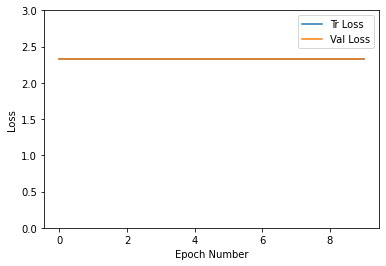

In [30]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

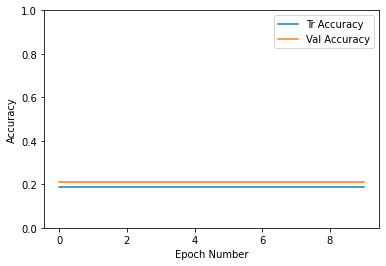

In [31]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 21 %


In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Viral Pneumonia is 0.0 %
Accuracy for class: Normal is 0.0 %
Accuracy for class: Covid is 70.0 %


c) Based on Question 2 b), answer the following questions: 
    
    i) Is the model overfitting? Why? (4 marks)
   <font color='blue'>YES, Because the model has a higher accuracy in training data than the validation data </font>
    
    ii) Propose two methods to reduce the effect of overfitting. (4 marks)
   <font color='blue'>Two methods that I propose are: (1) batch normalisation (2) drop out </font>
   
    iii) Implement the two proposed methods in Q2 c) ii) in the next cell and show that the overfitting has been reduced. (8 marks)

In [35]:
#1. DEFINE THE CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 is channels no, 6 is kernal no, 5 is size of kernal
        self.pool1 = nn.MaxPool2d(2, 2) # 2 is stride 
        self.batchnorm1 = nn.BatchNorm2d(6) # to improve the accuracy 
        self.conv2 = nn.Conv2d(6, 16, 5) # 16 is the output size
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(16 * 5* 5, 10)
        self.dropout = nn.Dropout(0.2) # to improve the accuracy 
        self.fc2 = nn.Linear(10, 3)
        # self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        #x = self.pool3(self.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.fc3(x)
        return x

In [36]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [37]:
# to check how many parameters in our model:

import torch
from torchvision import models
from torchsummary import summary

model = CNN()
model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                   [-1, 10]           4,010
              ReLU-8                   [-1, 10]               0
            Linear-9                    [-1, 3]              33
Total params: 6,915
Trainable params: 6,915
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.03
Estimated Total Size (MB): 0.15
-----------------------------------------------

In [38]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [40]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.0741, Accuracy: 44.6215%, 
		Validation : Loss : 1.0881, Accuracy: 39.3939%, Time: 16.8394s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.0741, Accuracy: 44.6215%, 
		Validation : Loss : 1.0881, Accuracy: 39.3939%, Time: 16.7702s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.0741, Accuracy: 44.6215%, 
		Validation : Loss : 1.0881, Accuracy: 39.3939%, Time: 16.8681s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.0741, Accuracy: 44.6215%, 
		Validation : Loss : 1.0881, Accuracy: 39.3939%, Time: 17.0362s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.0741, Accuracy: 44.6215%, 
		Validation : Loss : 1.0881, Accuracy: 39.3939%, Time: 16.9323s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.0741, Accuracy: 44.6215%, 
		Validation : Loss : 1.0881, Accuracy: 39.3939%, Time: 16.9911s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.0741, Accuracy: 44.6215%, 
		Validation : Loss : 1.0881, Accuracy: 39.3939%, Time: 16.9801s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.0741, Accura

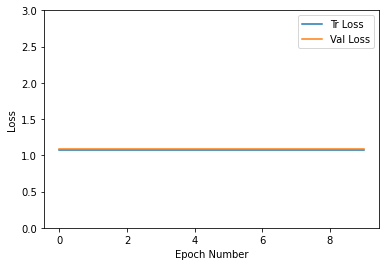

In [41]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

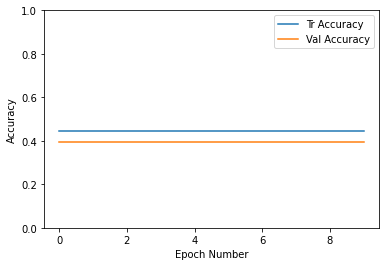

In [42]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [43]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 39 %


In [44]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Viral Pneumonia is 100.0 %
Accuracy for class: Normal is 0.0 %
Accuracy for class: Covid is 0.0 %


d) Replace your defined ConvNet in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the COVID-19 dataset. **(10 marks)**

In [45]:
model_ft = models.shufflenet_v2_x0_5(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

SyntaxError: ignored

In [ ]:
model_ft
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(trained_model)

e) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **(4 marks)**

<span style="color:blue">
    Your answer here </span>

**QUESTION 3** **[15 marks]**

In a machine vision project, you decide to design a door access control system based on hand gestures. Only those who shows the correct hand gesture will be granted the access. There are three gestures that are recognized as correct access passcode which are "shaka", "peace" and "thumbs up", as depicted in Fig. 2.

![pic](https://simplyorganizedhi.com/media/catalog/product/1/6/169500.jpg)

                                Fig. 2 Shaka,peace, and thumbs up


Using the end-to-end object detection pipeline that you have learned, develop your own hand gesture detector so that it can be incorporate to a door access control system.

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).

- 5 marks for plausible detection of each gesture.